# Decision Tree

1. **Aims and Objectives**

Following the exploratory data analysis and visualisations developed in Tableau, this section will  apply a supervised machine learning approach to predict the likelihood that a financial transaction is fraudulent. The model is trained on the pre-processed, labeled dataset, prepared in the `etl_process.ipynb` notebook. By using classification techniques, the goal is to identify key patterns and risk indicators that may signal potential money laundering or financial crime activity before the transaction occurs.

The workflow I will use for this supervised learning is
- Split the dataset into train and test set
- Fit the pipeline
- Evaluate your model. 

In [118]:
#step 0. Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

1. **Import the data**


In [124]:
#Step 1. Load the dataset
data = pd.read_csv ('/Users/nataliewaugh/Documents/DataCode/Detecting_Money_Laundering_Patterns-/data/cleaned_money_laundering_datasetrevised.csv') 

#Step 2. show the first few rows of the dataset
data.head()

,Origin Country,Amount (USD),Transaction Type,Date of Transaction,Person Involved,Industry,Destination Country,Reported by Authority,Source of Money,Money Laundering Risk Score,Shell Companies Involved,Financial Institution,Tax Haven Country,Domestic or Cross-Border,Origin Country Category,Destination Tax Haven Flag
0,Brazil,3267530.0,Offshore Transfer,2023-01-01 00:00:00,Person_1101,Construction,USA,True,Illegal,6,1,Bank_40,Singapore,Cross-Border,Upper-Middle / Partial Regulated,Non-Tax Haven
1,China,4965767.0,Stocks Transfer,2023-01-01 01:00:00,Person_7484,Luxury Goods,South Africa,False,Illegal,9,0,Bank_461,Bahamas,Cross-Border,Upper-Middle / Partial Regulated,Non-Tax Haven
2,UK,94168.0,Stocks Transfer,2023-01-01 02:00:00,Person_3655,Construction,Switzerland,True,Illegal,1,3,Bank_387,Switzerland,Cross-Border,High Income / Regulated,Tax Haven
3,UAE,386420.0,Cash Withdrawal,2023-01-01 03:00:00,Person_3226,Oil & Gas,Russia,False,Illegal,7,2,Bank_353,Panama,Cross-Border,High Income / Tax Haven,Non-Tax Haven
4,South Africa,643378.0,Cryptocurrency,2023-01-01 04:00:00,Person_7975,Real Estate,USA,True,Illegal,1,9,Bank_57,Luxembourg,Cross-Border,Upper-Middle / Regulated,Non-Tax Haven


2. **Prepare the data**

All categorical columns need to be converted into numerical representations before being used in most machine learning models. I will use One-Hot Encoding, a method that converts each category into a separate binary (boolean-like) column.

In [125]:
#Step 3 Drop columns that are not needed.
data = data.drop(columns=[
    'Date of Transaction',        
    'Person Involved',            
    'Financial Institution'        
])

In [126]:
#Step 4. Check data types.
print(data.dtypes)

Origin Country                  object
Amount (USD)                   float64
Transaction Type                object
Industry                        object
Destination Country             object
Reported by Authority             bool
Source of Money                 object
Money Laundering Risk Score      int64
Shell Companies Involved         int64
Tax Haven Country               object
Domestic or Cross-Border        object
Origin Country Category         object
Destination Tax Haven Flag      object
dtype: object


In [127]:
#Step 5. Encode all object and bool columns
data_encoded = pd.get_dummies(data, drop_first=True) 
#(drop_first=True: drops the first category in each column to avoid multicollinearity)

#Step 6 Show results of encoding# Check result
print(data_encoded.head())
print(data_encoded.dtypes)
print(data_encoded.shape)

   Amount (USD)  Reported by Authority  Money Laundering Risk Score  \
0     3267530.0                   True                            6   
1     4965767.0                  False                            9   
2       94168.0                   True                            1   
3      386420.0                  False                            7   
4      643378.0                   True                            1   

   Shell Companies Involved  Origin Country_China  Origin Country_India  \
0                         1                 False                 False   
1                         0                  True                 False   
2                         3                 False                 False   
3                         2                 False                 False   
4                         9                 False                 False   

   Origin Country_Russia  Origin Country_Singapore  \
0                  False                     False   
1             

This is an extra step to covert all boolean columns to integers. This will enable me to work with `pipeline` and `StandardScaler`. 

In [128]:
# Step7. Convert all boolean columns to integers (True → 1, False → 0)
bool_cols = data_encoded.select_dtypes(include=['bool']).columns
data_encoded[bool_cols] = data_encoded[bool_cols].astype(int)

In [146]:
print(data_encoded.dtypes)

Amount (USD)                                                float64
Reported by Authority                                         int64
Money Laundering Risk Score                                   int64
Shell Companies Involved                                      int64
Origin Country_China                                          int64
Origin Country_India                                          int64
Origin Country_Russia                                         int64
Origin Country_Singapore                                      int64
Origin Country_South Africa                                   int64
Origin Country_Switzerland                                    int64
Origin Country_UAE                                            int64
Origin Country_UK                                             int64
Origin Country_USA                                            int64
Transaction Type_Cryptocurrency                               int64
Transaction Type_Offshore Transfer              

In [150]:

print(data_encoded['Source of Money_Legal'].unique( ))   # unique labels after encoding (likely 0 and 1)
print(data_encoded['Source of Money_Legal'].value_counts())
print(data_encoded['Source of Money_Legal'].head(10))

[0 1]
Source of Money_Legal
0    7017
1    2983
Name: count, dtype: int64
0    0
1    0
2    0
3    0
4    0
5    1
6    1
7    0
8    0
9    0
Name: Source of Money_Legal, dtype: int64


The `Source of Money_Legal` is coded as follows;
- 0 = Illegal 
- 1 = Legal 

The data source has far more illegal transactions than legal. 


---

Now that the data set is fully numeric, we can proceed with the machine learning model.
- Split the dataset into train and test set
- Fit the pipeline
- Evaluate your model. 

In [139]:
from sklearn.preprocessing import LabelEncoder

#Step 7.1 Example: Fit label encoder on your original labels (y)
label_encoder = LabelEncoder()
label_encoder.fit(y)  # y is your original labels array or Series

# Now print the classes
print(label_encoder.classes_)

[0 1]


In [140]:
print(df['label'].value_counts())
print(df[['label']].head(10))

NameError: name 'df' is not defined

In [132]:
#Step 8 define the target column. Is the money legal or illegal?
target_col = ['Source of Money_Legal']  

X = data_encoded.drop(columns=['Source of Money_Legal']) # Features (all columns except the target)
y = data_encoded['Source of Money_Legal']          # Target (what I am predicting)

In [133]:
# Step 9. Split the dataset into training and testing sets
# from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [134]:
# Step 10. Train a Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [135]:
#Step 11. Make predictions
y_pred = model.predict(X_test)

In [136]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.578

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.69      0.69      1389
           1       0.31      0.32      0.32       611

    accuracy                           0.58      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.58      0.58      0.58      2000


Confusion Matrix:
 [[958 431]
 [413 198]]


In [137]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(
    class_weight='balanced',  # ⬅️ This tells the model to treat both classes equally
    random_state=42
)
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [110]:
y_pred = model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.5935

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71      1389
           1       0.33      0.33      0.33       611

    accuracy                           0.59      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.59      0.59      0.59      2000


Confusion Matrix:
 [[983 406]
 [407 204]]


In [111]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=100,
    max_depth=10,  # Add some control to reduce overfitting
    random_state=42
)

model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=42)

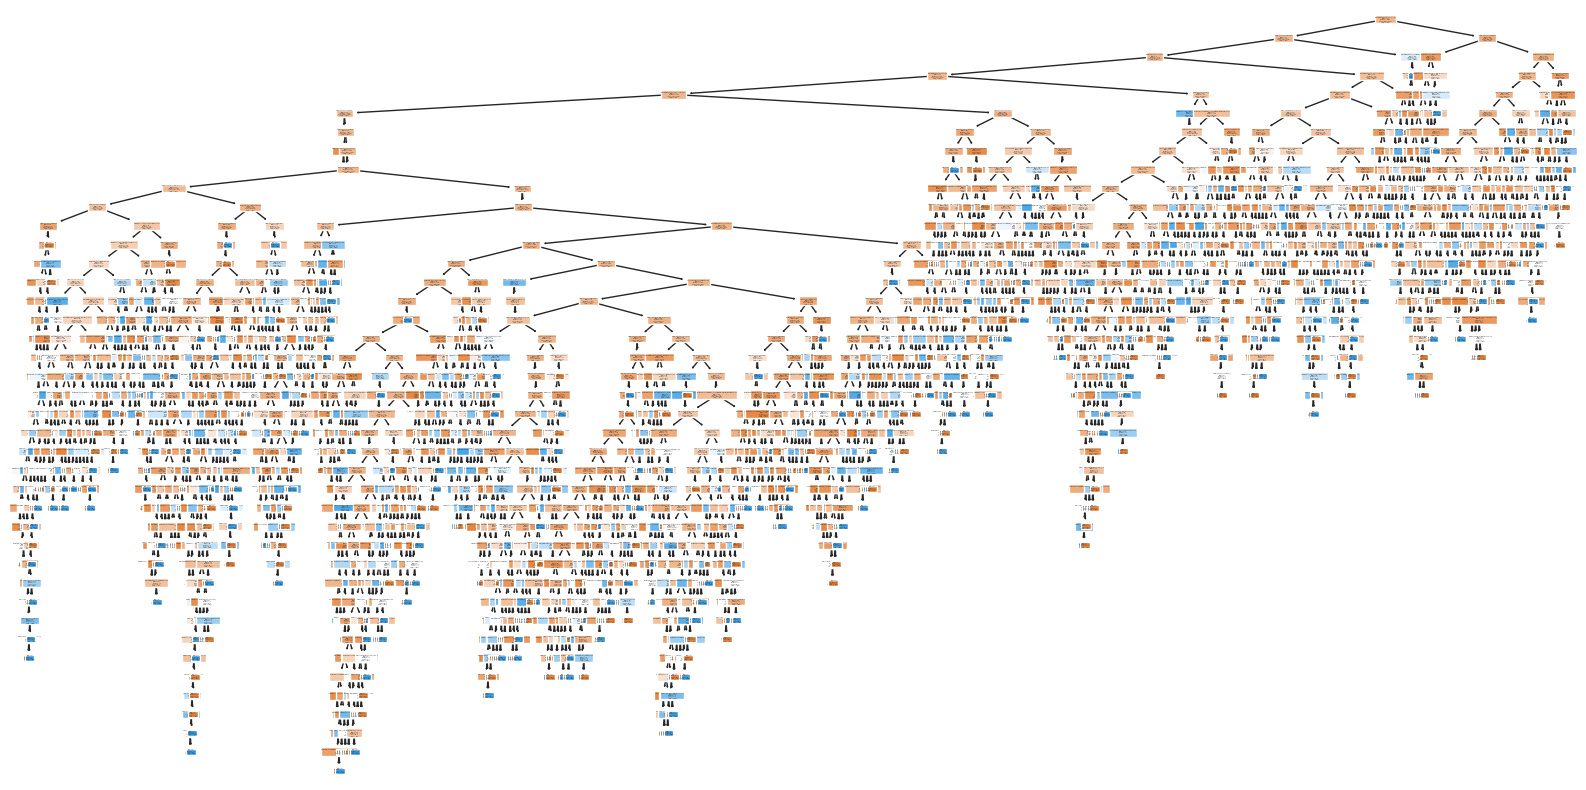

In [107]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=X.columns, class_names=['Illegal', 'Legal'], filled=True)
plt.show()

In [89]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Fit model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

In [90]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

RMSE: 1462806.72
R² Score: -0.05


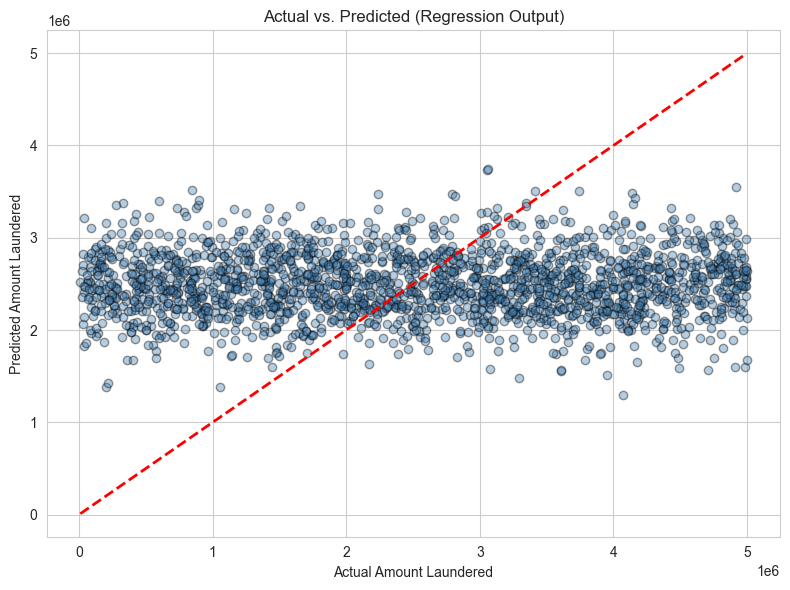

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.4, color='steelblue', edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)  # ideal line
plt.xlabel('Actual Amount Laundered')
plt.ylabel('Predicted Amount Laundered')
plt.title('Actual vs. Predicted (Regression Output)')
plt.grid(True)
plt.tight_layout()
plt.show()